# Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load Data

In [2]:
df=pd.read_csv('breast-cancer-wisconsin-data_data.csv')

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
df.shape

(569, 33)

# Data Preprocessing

handle missing values

In [5]:
df.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [6]:
#drop unnamed column because all its entries are empty
df.drop("Unnamed: 32", axis=1, inplace=True)
df.isnull().sum().sum()

0

handle duplicates

In [7]:
df.duplicated().any()

False

handle outliers

In [8]:
def find_outliers(df, threshold=1.5):
    outliers_count = {}
    
    for column in df.columns:
        # Check if the column contains numeric data
        if pd.api.types.is_numeric_dtype(df[column]):
            # Calculate the IQR for the column
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            
            # Define the lower and upper bounds for outliers
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            # Identify and count outliers
            outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
            outliers_count[column] = len(outliers)
        else:
            outliers_count[column] = 0  # Non-numeric column
        
    return outliers_count


# Call the function to find outliers
outliers_count_result = find_outliers(df)

# Print the number of outliers in each column
for column, count in outliers_count_result.items():
    print(f"Number of outliers in {column}: {count}")


Number of outliers in id: 81
Number of outliers in diagnosis: 0
Number of outliers in radius_mean: 14
Number of outliers in texture_mean: 7
Number of outliers in perimeter_mean: 13
Number of outliers in area_mean: 25
Number of outliers in smoothness_mean: 6
Number of outliers in compactness_mean: 16
Number of outliers in concavity_mean: 18
Number of outliers in concave points_mean: 10
Number of outliers in symmetry_mean: 15
Number of outliers in fractal_dimension_mean: 15
Number of outliers in radius_se: 38
Number of outliers in texture_se: 20
Number of outliers in perimeter_se: 38
Number of outliers in area_se: 65
Number of outliers in smoothness_se: 30
Number of outliers in compactness_se: 28
Number of outliers in concavity_se: 22
Number of outliers in concave points_se: 19
Number of outliers in symmetry_se: 27
Number of outliers in fractal_dimension_se: 28
Number of outliers in radius_worst: 17
Number of outliers in texture_worst: 5
Number of outliers in perimeter_worst: 15
Number o

In [9]:
import pandas as pd
import numpy as np

def handle_outliers_capping(df, threshold=1.5):
    capped_df = df.copy()
    outliers_count = {}

    for column in df.columns:
        # Check if the column contains numeric data
        if pd.api.types.is_numeric_dtype(df[column]):
            # Calculate the IQR for the column
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1

            # Define the lower and upper bounds for capping
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR

            # Cap the values beyond the bounds
            capped_df[column] = np.where(capped_df[column] < lower_bound, lower_bound,
                                         np.where(capped_df[column] > upper_bound, upper_bound, capped_df[column]))

            # Count the number of outliers
            outliers_count[column] = np.sum((df[column] < lower_bound) | (df[column] > upper_bound))
            df= capped_df
        else:
            # If the column is non-numeric, set the outlier count to 0
            outliers_count[column] = 0

    return df, outliers_count

# Call the function to handle outliers using capping
df, outliers_count_result = handle_outliers_capping(df)

# Print the number of outliers in each column
for column, count in outliers_count_result.items():
    print(f"Number of outliers in {column}: {count}")


Number of outliers in id: 81
Number of outliers in diagnosis: 0
Number of outliers in radius_mean: 0
Number of outliers in texture_mean: 0
Number of outliers in perimeter_mean: 0
Number of outliers in area_mean: 0
Number of outliers in smoothness_mean: 0
Number of outliers in compactness_mean: 0
Number of outliers in concavity_mean: 0
Number of outliers in concave points_mean: 0
Number of outliers in symmetry_mean: 0
Number of outliers in fractal_dimension_mean: 0
Number of outliers in radius_se: 0
Number of outliers in texture_se: 0
Number of outliers in perimeter_se: 0
Number of outliers in area_se: 0
Number of outliers in smoothness_se: 0
Number of outliers in compactness_se: 0
Number of outliers in concavity_se: 0
Number of outliers in concave points_se: 0
Number of outliers in symmetry_se: 0
Number of outliers in fractal_dimension_se: 0
Number of outliers in radius_worst: 0
Number of outliers in texture_worst: 0
Number of outliers in perimeter_worst: 0
Number of outliers in area_w

Data balance

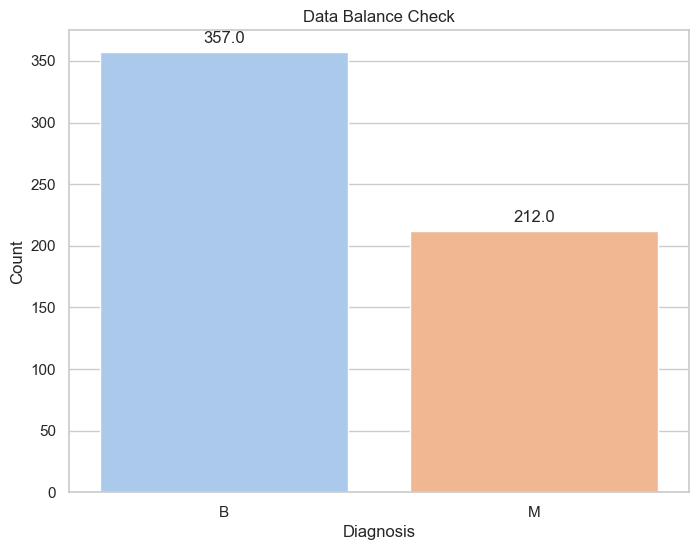

In [10]:
# Set up the plotting style
sns.set(style="whitegrid")

# Count the occurrences of each diagnosis
diagnosis_counts = df['diagnosis'].value_counts()

# Plot the bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x=diagnosis_counts.index, y=diagnosis_counts.values, palette="pastel")

# Add values on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set plot labels and title
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.title("Data Balance Check")

# Show the plot
plt.show()

Data encoding

In [11]:
# Identify object columns
object_columns = df.select_dtypes(include=['object']).columns

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode object columns
for column in object_columns:
    df[column] = label_encoder.fit_transform(df[column])

# Display the encoded DataFrame
print("Encoded DataFrame:")
df

Encoded DataFrame:


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302.0,1,17.99,10.38,122.80,1001.0,0.118400,0.22862,0.28241,0.14710,...,25.380,17.33,184.60,1937.05,0.16220,0.62695,0.7119,0.2654,0.41915,0.11890
1,842517.0,1,20.57,17.77,132.90,1326.0,0.084740,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1937.05,0.12380,0.18660,0.2416,0.1860,0.27500,0.08902
2,20728995.5,1,19.69,21.25,130.00,1203.0,0.109600,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.00,0.14440,0.42450,0.4504,0.2430,0.36130,0.08758
3,20728995.5,1,11.42,20.38,77.58,386.1,0.133695,0.22862,0.24140,0.10520,...,14.910,26.50,98.87,567.70,0.19010,0.62695,0.6869,0.2575,0.41915,0.12301
4,20728995.5,1,20.29,14.34,135.10,1297.0,0.100300,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.00,0.13740,0.20500,0.4000,0.1625,0.23640,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424.0,1,21.56,22.39,142.00,1326.3,0.111000,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,1937.05,0.14100,0.21130,0.4107,0.2216,0.20600,0.07115
565,926682.0,1,20.13,28.25,131.20,1261.0,0.097800,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.00,0.11660,0.19220,0.3215,0.1628,0.25720,0.06637
566,926954.0,1,16.60,28.08,108.30,858.1,0.084550,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.00,0.11390,0.30940,0.3403,0.1418,0.22180,0.07820
567,927241.0,1,20.60,29.33,140.10,1265.0,0.117800,0.22862,0.28241,0.15200,...,25.740,39.42,184.60,1821.00,0.16500,0.62695,0.7855,0.2650,0.40870,0.12301


# EXploratory Data Analysis

Statistical summary

In [12]:
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,5.101582e+06,0.372583,14.062916,19.254736,91.543787,639.765202,0.096266,0.103222,0.086937,0.048552,...,16.183882,25.648453,106.705369,849.907821,0.132209,0.249883,0.268754,0.114606,0.287616,0.083342
std,7.070587e+06,0.483918,3.340025,4.187510,23.047218,305.343508,0.013685,0.049386,0.073900,0.037633,...,4.587249,6.054406,31.957777,475.645240,0.022320,0.142851,0.197461,0.065732,0.053868,0.015993
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.057975,0.019380,0.000000,0.000000,...,7.930000,12.020000,50.410000,185.200000,0.072500,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,2.072900e+07,1.000000,21.900000,30.245000,147.495000,1326.300000,0.133695,0.228620,0.282410,0.154535,...,27.460000,42.680000,187.335000,1937.050000,0.190100,0.626950,0.785500,0.291000,0.419150,0.123010


Data correlation

In [13]:
# Select the first 6 numeric attributes
numeric_attributes = df.iloc[:, :6]

# Calculate the correlation matrix
correlation_matrix = numeric_attributes.corr()
correlation_matrix


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean
id,1.000000,0.065270,0.102080,0.151840,0.102812,0.097370
diagnosis,0.065270,1.000000,0.745217,0.419123,0.759006,0.752786
radius_mean,0.102080,0.745217,1.000000,0.332760,0.997692,0.993891
texture_mean,0.151840,0.419123,0.332760,1.000000,0.339588,0.341552
perimeter_mean,0.102812,0.759006,0.997692,0.339588,1.000000,0.991861
area_mean,0.097370,0.752786,0.993891,0.341552,0.991861,1.000000


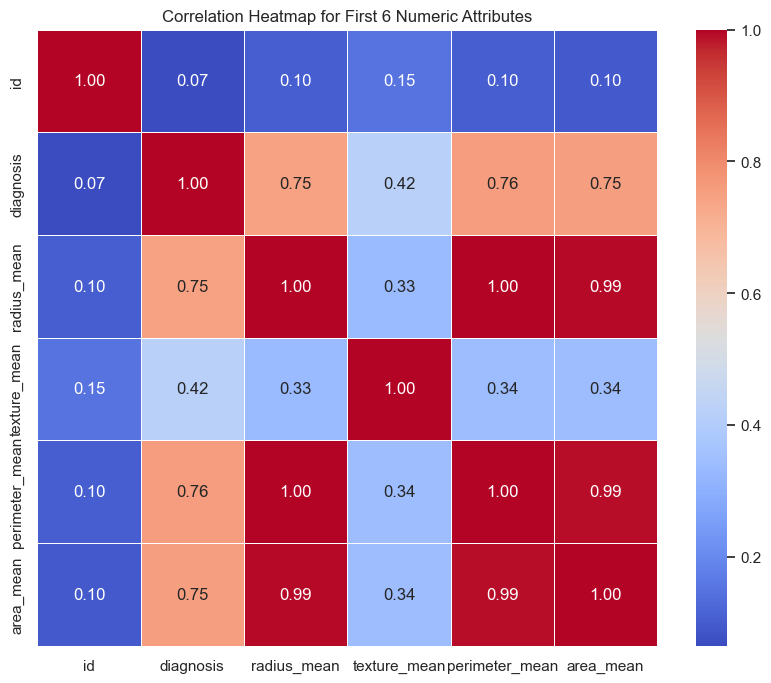

In [14]:
# Set up the plotting style
sns.set(style="white")

# Create a heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Set plot title
plt.title("Correlation Heatmap for First 6 Numeric Attributes")

# Show the plot
plt.show()

# Feature Selection

In [15]:
# Ignore all warnings
warnings.filterwarnings("ignore")
# Separate features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize logistic regression model
logreg_model = LogisticRegression()

# Initialize RFE with the logistic regression model
rfe = RFE(estimator=logreg_model, step=1)

# Fit RFE to the training data
rfe.fit(X_train, y_train)

# Select the features chosen by RFE
selected_features = X_train.columns[rfe.support_]
#Display the selected features
print("Selected Features:")
print(selected_features)







Selected Features:
Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'concavity_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'compactness_worst',
       'concavity_worst', 'symmetry_worst'],
      dtype='object')


# Data splitting

In [16]:
X = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Baseline (Logistic Regression) Model

Accuracy: 0.9736842105263158
Precision: 0.9761904761904762
Recall: 0.9534883720930233
F1 Score: 0.9647058823529412

Confusion Matrix:


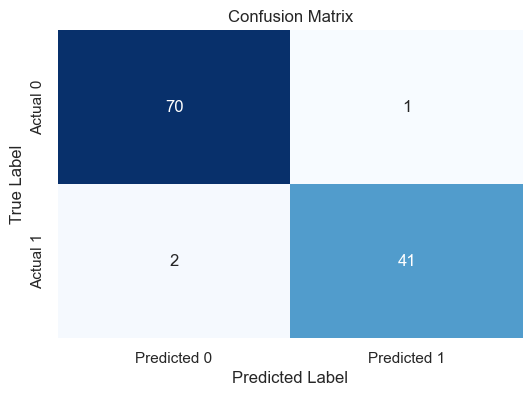

In [17]:
# Ignore all warnings
warnings.filterwarnings("ignore")
# Initialize logistic regression model
logreg_model = LogisticRegression(random_state=42)

# Train the model
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
lr_accuracy = accuracy_score(y_test, y_pred)
lr_precision = precision_score(y_test, y_pred)
lr_recall = recall_score(y_test, y_pred)
lr_f1 = f1_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the evaluation metrics
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1 Score:", lr_f1)
print("\nConfusion Matrix:")

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# XGBoost Model

XGB Accuracy: 0.9649122807017544
XGB Precision: 0.9534883720930233
XGB Recall: 0.9534883720930233
XGB F1 Score: 0.9534883720930233

Confusion Matrix:


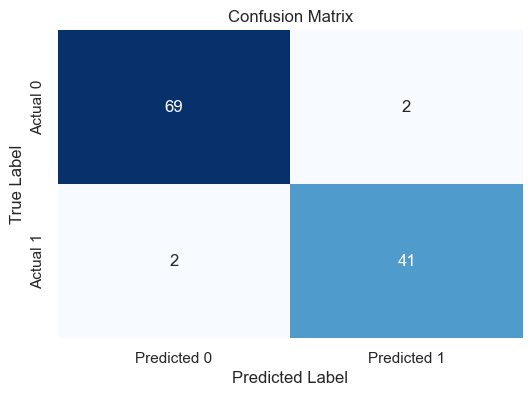

In [18]:
# Initialize XGBoost model
xgb_model = XGBClassifier(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_precision = precision_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_f1 = f1_score(y_test, y_pred)

# Confusion matrix
xgb_conf_matrix = confusion_matrix(y_test, y_pred)

# Display the evaluation metrics with model initials
print("XGB Accuracy:", xgb_accuracy)
print("XGB Precision:", xgb_precision)
print("XGB Recall:", xgb_recall)
print("XGB F1 Score:", xgb_f1)
print("\nConfusion Matrix:")

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(xgb_conf_matrix , annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Random Forest Classifier Model

RF Accuracy: 0.956140350877193
RF Precision: 0.9523809523809523
RF Recall: 0.9302325581395349
RF F1 Score: 0.9411764705882352

RF Confusion Matrix:


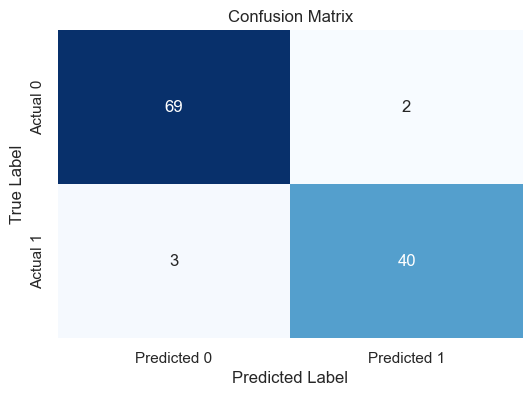

In [19]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)

# Confusion matrix
rf_conf_matrix = confusion_matrix(y_test, y_pred)

# Display the evaluation metrics with model initials
print("RF Accuracy:", rf_accuracy)
print("RF Precision:", rf_precision)
print("RF Recall:", rf_recall)
print("RF F1 Score:", rf_f1)
print("\nRF Confusion Matrix:")
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(rf_conf_matrix , annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# CNN Model

4/4 [==============================] - 0s 0s/step
CNN Accuracy: 0.956140350877193
CNN Precision: 0.975
CNN Recall: 0.9069767441860465
CNN F1 Score: 0.9397590361445783

CNN Confusion Matrix:


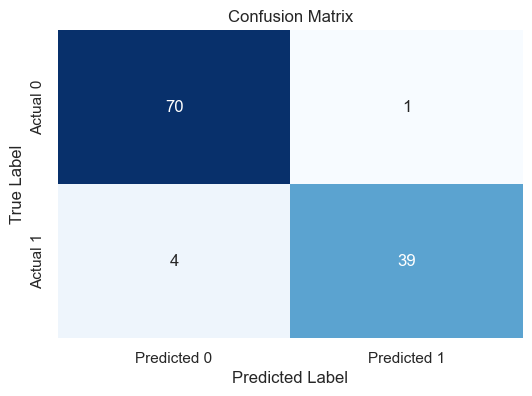

In [20]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Make predictions on the test set
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

# Evaluate the model
cnn_accuracy = accuracy_score(y_test, y_pred)
cnn_precision = precision_score(y_test, y_pred)
cnn_recall = recall_score(y_test, y_pred)
cnn_f1 = f1_score(y_test, y_pred)

# Confusion matrix
cnn_conf_matrix = confusion_matrix(y_test, y_pred)

# Display the evaluation metrics with model initials
print("CNN Accuracy:", cnn_accuracy)
print("CNN Precision:", cnn_precision)
print("CNN Recall:", cnn_recall)
print("CNN F1 Score:", cnn_f1)
print("\nCNN Confusion Matrix:")
plt.figure(figsize=(6, 4))
sns.heatmap(cnn_conf_matrix , annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Model Comparison

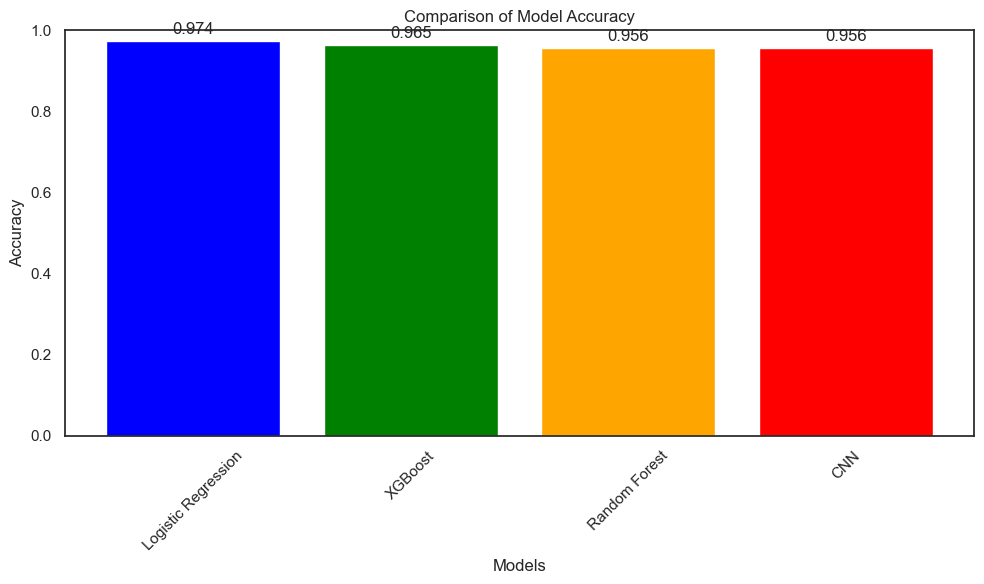

In [21]:
# Accuracy values for each model
accuracy_values = [lr_accuracy, xgb_accuracy, rf_accuracy, cnn_accuracy]
model_names = ['Logistic Regression', 'XGBoost', 'Random Forest', 'CNN']

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy')
plt.ylim(0, 1)  # Set the y-axis limit to ensure proper scale
plt.xticks(rotation=45)
plt.tight_layout()

# Add accuracy values on top of the bars
for i, v in enumerate(accuracy_values):
    plt.text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom')

plt.show()